---


<a href="statworx.com"><img src="https://www.statworx.com/wp-content/uploads/2021/11/statworx-Logo-Blue.svg" style="height:40px; float:right"></a>

# Machine Learning for Marketing
## Uplift Modeling

15.07.2022

---

### Introduction to Uplift Modeling


### Install Required Packages

In [1]:
%%capture
!pip install causalml

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import causalml
from causalml.inference.tree import UpliftRandomForestClassifier, UpliftTreeClassifier
from causalml.metrics import plot_gain

In [3]:
df = pd.read_csv("../input/uplift-modeling/criteo-uplift-v2.1.csv")
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0


### Data Exploration

In [4]:
print(df.shape)
print(df.treatment.value_counts())
print(df.treatment.value_counts(normalize = True))

(13979592, 16)
1    11882655
0     2096937
Name: treatment, dtype: int64
1    0.85
0    0.15
Name: treatment, dtype: float64


In [5]:
df.pivot_table(
    values="conversion",
    index="treatment",
    aggfunc=[np.mean, np.size],
    margins=True
)

,mean,size
,conversion,conversion
treatment,,
0,0.001938,2096937
1,0.003089,11882655
All,0.002917,13979592


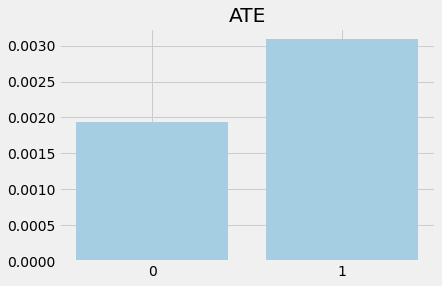

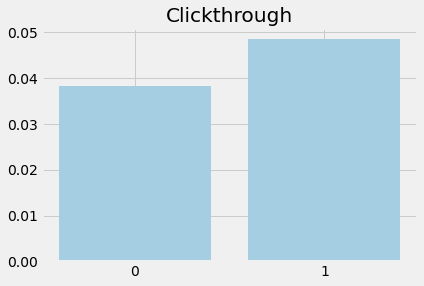

In [6]:
ate = df.groupby("treatment").conversion.agg(avg_conv=("mean"), sum_conv=("sum"))
plt.bar(x=ate.index, height=ate.avg_conv, tick_label=ate.index)
plt.title("ATE")
plt.show()

click = df.groupby("treatment").visit.agg(avg_click=("mean"))
plt.bar(x=click.index, height=click.avg_click, tick_label=click.index)
plt.title("Clickthrough")
plt.show()

### Modeling

In [7]:
model_df = df.copy()
model_df["is_treated"] = model_df.treatment
model_df.treatment = np.where(model_df.treatment==1, "treatment", "control")
model_df.drop(columns=["visit", "exposure"], inplace=True)

df_train, df_test = train_test_split(model_df, test_size=0.2, random_state=42)

In [8]:
uplift_model = UpliftTreeClassifier(control_name='control')
uplift_model.fit(df_train.iloc[:, :12].values,
         treatment=df_train['treatment'].values,
         y=df_train['conversion'].values)
p = uplift_model.predict(df_test.iloc[:, :12].values)

In [9]:
# uplift_model = UpliftRandomForestClassifier(control_name='control')
#
# uplift_model.fit(df_train.iloc[:, :12].values,
#                  treatment=df_train['treatment'].values,
#                  y=df_train['conversion'].values)

In [10]:
# df_res = uplift_model.predict(df_test.iloc[:, :12].values, full_output=True)
# df_res.head()

In [11]:
y_pred = uplift_model.predict(df_test.iloc[:, :12].values)
result = pd.DataFrame(
    y_pred,
    columns=uplift_model.classes_
)
result["delta_treatment"] = result.treatment - result.control
result.head()

,control,treatment,delta_treatment
0,0.000874,0.001741,0.000866
1,0.000874,0.001741,0.000866
2,0.003001,0.003679,0.000678
3,0.003001,0.003679,0.000678
4,0.003001,0.003679,0.000678


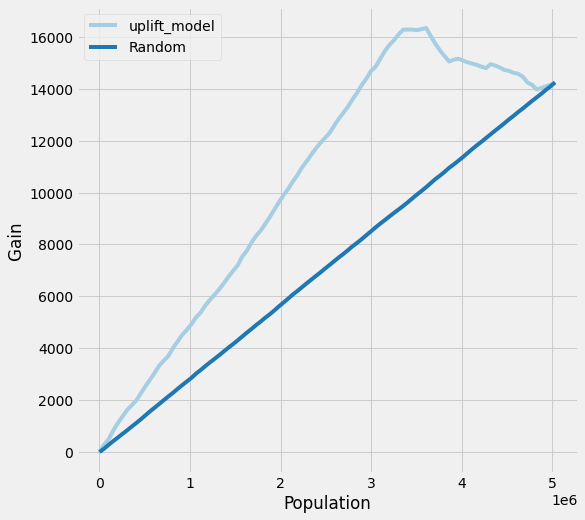

In [12]:
pred_overview = pd.DataFrame({
    "conversion": df_test.conversion,
    "is_treated": df_test.is_treated,
    "uplift_model": result.delta_treatment
})

plot_gain(pred_overview, outcome_col="conversion", treatment_col="is_treated")
plt.show()

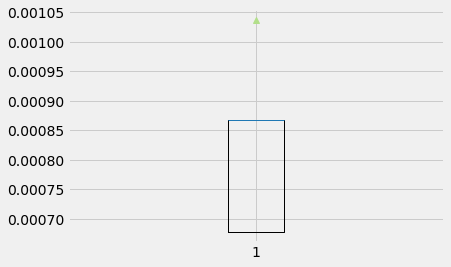

In [13]:
uplift_dist = plt.boxplot(result.delta_treatment, showfliers=False, showmeans=True)